## Step 2: copying the msaexp-reduced spectra to *_cal.fits files, preparing for PypeIt extraction.

###  prior to running this notebook:

- Run through Step_1_msaexp_reduction.ipynb
- Run jwst's spec2pipeline. The following cell gives how I run it.

In [ ]:
# 
from jwst.pipeline import Spec2Pipeline
import glob
import os

cwd = os.getcwd()
scifiles_all = glob.glob('./*_rate.fits')

param_dict_spec2 = {
    'extract_2d': {'save_results': True},
    'bkg_subtract': {'skip': False},
    'imprint_subtract': {'save_results': True}, # TODO Check up on whether imprint subtraction is being done by us???
    'master_background_mos': {'skip': False},
    # Default to setting the source type to extended for MSA data and point for FS data. This impacts flux calibration.
    'srctype': {'source_type': 'EXTENDED'},
    'resample_spec': {'skip': True},
    'extract_1d': {'skip': True},
    'flat_field': {'save_interpolated_flat': True},  # Flats appear to be just nonsense. So skip for now.
    'nsclean': {'save_results': True, 'skip': False, 'fit_method': 'median', 'fit_by_channel': True, 'save_noise': True}
}

if not os.path.isdir(cwd+'/spec2pipe/'):
    os.mkdir(cwd+'/spec2pipe/')

    # Run the spec2 pipeline
for sci in scifiles_all:
    #print(sci)
    Spec2Pipeline.call(sci, save_results=True,\
                       output_dir=cwd+'/spec2pipe/',\
                       steps=param_dict_spec2)

2025-09-23 21:27:04,876 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /Users/minghao/anaconda3/envs/jwst_pypeit/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:97: RuntimeWarning: Invalid interval: upper bound -19.70886864491422 is strictly less than lower bound -0.5.
  warnings.warn(

2025-09-23 21:27:04,989 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /Users/minghao/anaconda3/envs/jwst_pypeit/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:97: RuntimeWarning: Invalid interval: upper bound -69.30808594074779 is strictly less than lower bound -0.5.
  warnings.warn(

2025-09-23 21:27:05,036 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /Users/minghao/anaconda3/envs/jwst_pypeit/lib/python3.12/site-packages/astropy/modeling/bounding_box.py:97: RuntimeWarning: Invalid interval: upper bound -161.69351895428508 is strictly less than lower bound -0.5.
  warnings.warn(

2025-09-23 21:27:05,143 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /Users/minghao/ana

### Now let's continue with msaexp and PypeIt

In [20]:

import numpy as np

os.environ["CRDS_PATH"] = "/Users/minghao/Research/Projects/JWST/dependencies/crds_cache/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

from astropy.io import fits

In [16]:
DO_NOT_USE = 4

In [17]:
import os
import glob
import yaml
import warnings
import time

import numpy as np
import matplotlib.pyplot as plt

import grizli
from grizli import utils, jwst_utils
jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy.io.fits as pyfits
import jwst.datamodels
import jwst

import mastquery.jwst

import msaexp
from msaexp import pipeline
import msaexp.slit_combine

print(f'jwst version = {jwst.__version__}')
print(f'grizli version = {grizli.__version__}')
print(f'msaexp version = {msaexp.__version__}')

plt.rcParams['scatter.marker'] = '.'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['grid.linestyle'] = ':'

jwst version = 1.17.1
grizli version = 1.12.10
msaexp version = 0.9.10


In [18]:
from copy import deepcopy

def safe_replace_slice(orig_arr, new_arr, slitslice):
    copy_arr = deepcopy(orig_arr)
    copy_arr[slitslice] = new_arr
    return copy_arr

### First, we need to reduce the spectra of individual objects with msaexp



In [5]:
group_kws = dict(
    diffs=True, # For nod differences
    #undo_barshadow=2, # For msaexp barshadow correction
    min_bar=0.35, # minimum allowed value for the (inverse) bar shadow correction
    position_key="y_index",
    trace_with_ypos=True, # Include expected y shutter offset in the trace
    trace_from_yoffset=True,
    #flag_profile_kwargs=None, # Turn off profile flag
    #bad_shutter_names=[-1]
)

flag_profile_kwargs = dict(require_multiple=True, make_plot=True, grow=2, nfilt=-32)

group_kws['diffs'] = True
group_kws['flag_profile_kwargs'] = flag_profile_kwargs

In [6]:
# these files are from Step 1 reduction.

all_reduced_2d = glob.glob('jw04713*_phot.*.4713_*.fits')

In [7]:
all_objid = []
for f in all_reduced_2d:
    try:
        objid = int(f.split('.')[-2].split('_')[-1])
    except ValueError:
        continue
    if not objid in all_objid:
        all_objid.append(objid)

In [8]:
# make a directory to save the reduced data for each object
os.system('mkdir xobj_saves')

0

In [9]:
import pickle

In [10]:
def save_xobj(xobj, outdir):
    for key in xobj.keys():
        slits = xobj[key]['obj'].slits
        for index in range(len(xobj[key]['obj'].files)):
            filename = xobj[key]['obj'].files[index]

            shape = xobj[key]['obj'].shapes[index]
            sh = xobj[key]['obj'].sh
            hotpix = xobj[key]['obj'].flagged_hot_pixels[index][0].reshape(shape)

            # other data need special treatment
            slit = slits[index]

            data = safe_replace_slice(slit.data, \
                                      xobj[key]['obj'].data[index].reshape(sh),\
                                     slit.slice)
            dq = safe_replace_slice(slit.dq, \
                                    xobj[key]['obj'].dq[index].reshape(sh),\
                                     slit.slice)
            var_poisson = safe_replace_slice(slit.var_poisson, \
                                             xobj[key]['obj'].var_poisson[index].reshape(sh),\
                                     slit.slice)
            var_rnoise = safe_replace_slice(slit.var_rnoise, \
                                            xobj[key]['obj'].var_rnoise[index].reshape(sh),\
                                     slit.slice)
            
            hotpix[hotpix>0] = DO_NOT_USE
            dqall = np.bitwise_or(dq, hotpix)
            
            # save it
            outfile = filename.replace('.fits', 'tmp.fits')
            hdu0 = fits.PrimaryHDU()
            #SCI, DQ, ERR, WAVELENGTH, BARSHADOW, VAR_POISSON, VAR_RNOISE, VAR_FLAT, PATHLOSS_PS, PATHLOSS_UN
            hdu1 = fits.ImageHDU(data=data, name='DATA')
            hdu2 = fits.ImageHDU(data=dqall, name='DQ')
            hdu3 = fits.ImageHDU(data=var_poisson, name='VAR_POISSON')
            hdu4 = fits.ImageHDU(data=var_rnoise, name='VAR_RNOISE')
            #hdu5 = fits.ImageHDU(data=WAVELENGTH, name='WAVELENGTH')

            hdulist = fits.HDUList([hdu0, hdu1, hdu2, hdu3, hdu4])
            
            hdulist.writeto(outdir+'/'+outfile, overwrite=True)

['jw04713001001_03101_00002_nrs1_phot.043.4713_10116.fits', 'jw04713001001_03101_00003_nrs1_phot.043.4713_10116.fits', 'jw04713001001_03101_00004_nrs1_phot.043.4713_10116.fits']
# (2025-09-24 04:17:30.854)

slit_combine.extract_spectra(**{'target': '10116', 'root': 'original10116', 'path_to_files': './', 'files': ['jw04713001001_03101_00002_nrs1_phot.043.4713_10116.fits', 'jw04713001001_03101_00003_nrs1_phot.043.4713_10116.fits', 'jw04713001001_03101_00004_nrs1_phot.043.4713_10116.fits'], 'do_gratings': ['PRISM', 'G395H', 'G395M', 'G235M', 'G140M'], 'join': [0, 3, 5], 'exposure_groups': None, 'split_uncover': True, 'stuck_threshold': 0.3, 'valid_frac_threshold': 0.1, 'pad_border': 2, 'sort_by_sn': False, 'position_key': 'y_index', 'mask_cross_dispersion': None, 'cross_dispersion_mask_type': 'trace', 'trace_from_yoffset': True, 'reference_exposure': 'auto', 'trace_niter': 4, 'offset_degree': 0, 'degree_kwargs': {}, 'recenter_all': False, 'free_trace_offset': False, 'nod_offset': None, '

2025-09-23 21:17:48,942 - stpipe - WARNING - /Users/minghao/anaconda3/envs/jwst_pypeit/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-09-23 21:17:48,946 - stpipe - WARNING - /Users/minghao/anaconda3/envs/jwst_pypeit/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



original10116_g140m-f070lp_4713_10116.spec.fits


2025-09-23 21:17:49,526 - stpipe - WARNING - /Users/minghao/anaconda3/envs/jwst_pypeit/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(

2025-09-23 21:17:49,528 - stpipe - WARNING - /Users/minghao/anaconda3/envs/jwst_pypeit/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



FileNotFoundError: [Errno 2] No such file or directory: './msaexp_reduced/msaexp_10116_g140m-f070lp.fits'

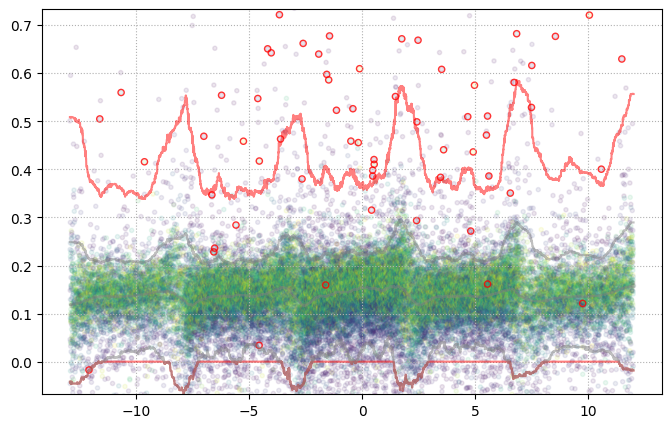

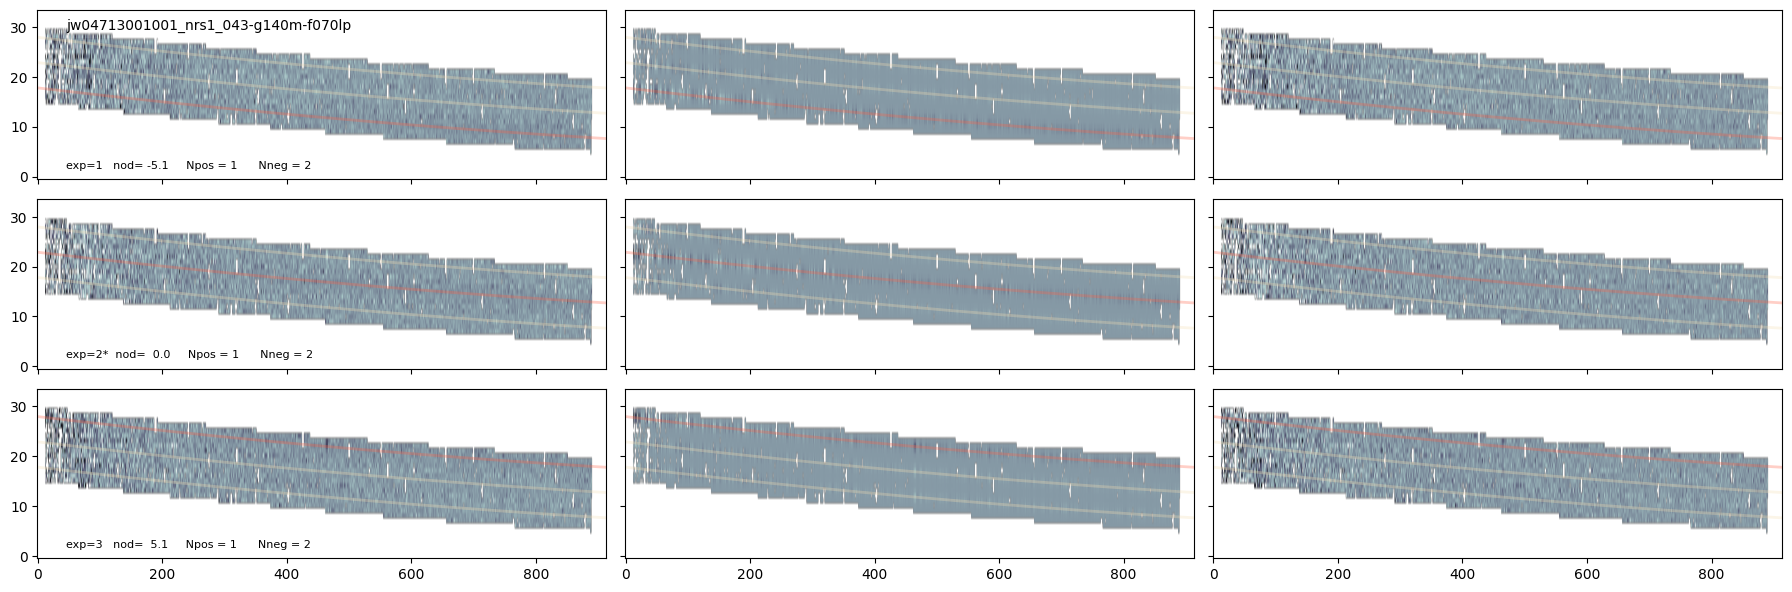

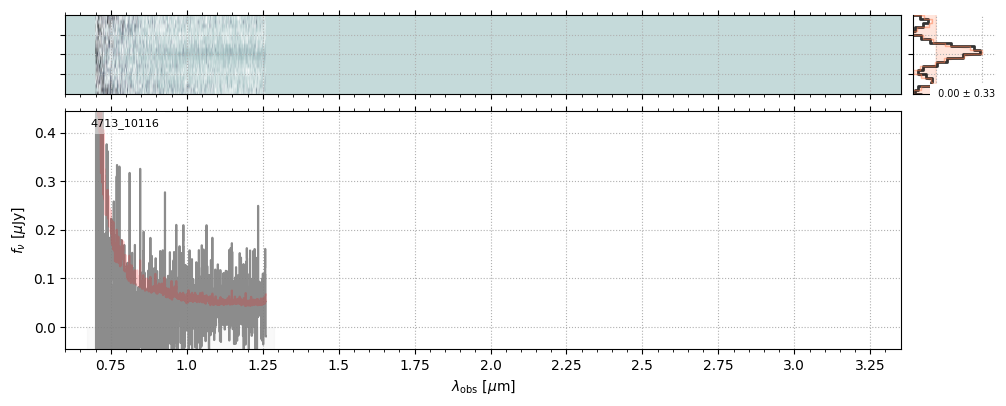

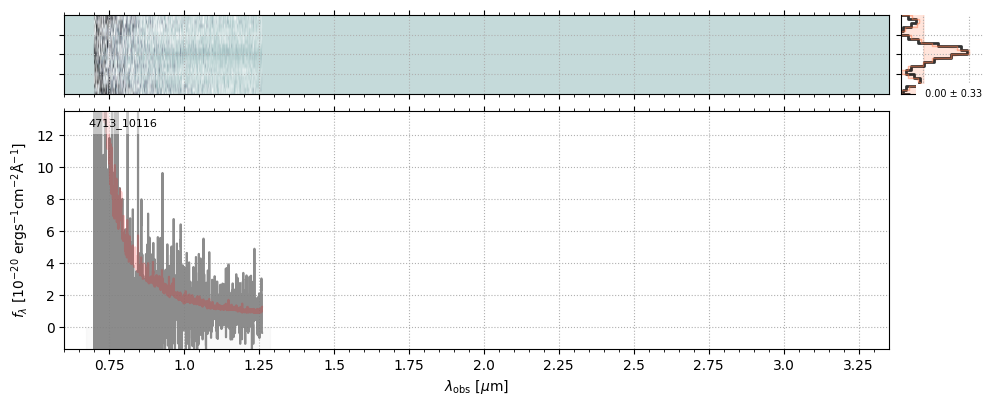

In [11]:
DRIZZLE_KWS = dict(
    step=1,
    with_pathloss=True,
    wave_sample=1.05,
    ny=13,
    dkws=dict(oversample=16, pixfrac=0.8),
)

for objid in all_objid:
    
    files = glob.glob(f'jw*_phot*{objid}.fits')
    files.sort()
    print(files)
    
    outroot = 'original%d'%objid
    hdul, xobj = msaexp.slit_combine.extract_spectra(
                target=str(objid),
                root=outroot,
                **group_kws,
                get_xobj=True,
                files=files,
                drizzle_kws=DRIZZLE_KWS,
                undo_barshadow=2
                )

    for key in hdul.keys():
        hdul[key].writeto(f'./msaexp_reduced/msaexp_{objid}_{key}.fits')
    
#    for key in xobj.keys():
#        save_xobj(xobj, './xobj_saves/')

### we can now update the cal files, so that PypeIt can read them properly

In [12]:
def update_cal_file(calfile, msaexp_out_dir):
    # make a backup
    calfile_old = calfile.replace('cal', 'calold')
    calfile_new = calfile.replace('cal', 'calnew')
    os.system('cp %s %s'%(calfile, calfile_old))

    hdulist = fits.open(calfile)
    for index in range(1, len(hdulist)):
        if hdulist[index].header['EXTNAME']=='SCI':
            #print(hdulist[index].header.keys)
            srcname = hdulist[index].header['SRCNAME']
            sltid = hdulist[index].header['SLITID']
            #print(srcname, sltid)
            
            msaexp_tmpfile_root = os.path.basename(calfile).replace('cal.fits', 'phot')+\
                                '.%03d.'%hdulist[index].header['SLITID  ']+\
                                srcname+'tmp.fits'
            msaexp_tmpfile = os.path.join(msaexp_out_dir, msaexp_tmpfile_root)
            if not os.path.exists(msaexp_tmpfile):
                #print(msaexp_tmpfile_root)
                continue

            else:
                msaexp_hdus = fits.open(msaexp_tmpfile)
                hdulist[index].data = msaexp_hdus[1].data
                hdulist[index+1].data = msaexp_hdus[2].data
                hdulist[index+5].data = msaexp_hdus[3].data
                hdulist[index+6].data = msaexp_hdus[4].data

        else:
            continue

    hdulist.writeto(calfile_new, overwrite=True)
    hdulist.close()

In [13]:
calfiles = glob.glob('./spec2pipe/jw04713*_cal.fits')
calfiles.sort()
#len(calfiles)

for f in calfiles:
    update_cal_file(f, './xobj_saves/')

### OK, now you should be able to run PypeIt reduction for the files (please go to step 3).